# CO$_2$ Relief Modeling

Modern refrigeration and heat pump systems run on so-called natural refrigerations, such as carbon dioxide. One challenge assocatiated with carbon dioxide is that it needs high pressures to operate, and therefore, requires the design and implementation of pressure relief systems. In this problem we will analyze a simple relief process. For more information about this industry please see the International Institute of All-natural Refrigeration ([IIAR](https://www.iiar.org)).

Conservation of mass:

$$ m_\text{in} - m_\text{out} = \Delta m_\text{CV} $$

For our problem here, we only have mass leaving, therefore:

$$ - m_\text{out} = \Delta m_\text{CV} $$

Conservation of energy:

$$E_\text{in} - E_\text{out} = \Delta E_\text{CV} $$ 

$$\left[Q_\text{in} + W_\text{in} + \sum\limits_\text{in}m \theta \right] - \left[Q_\text{out} + W_\text{out} + \sum\limits_\text{out}m \theta \right] = \left(m_2e_2 - m_1e_1 \right)_\text{CV} $$ 

where

$$\theta = h + \text{ke} + \text{pe} $$

$$e = u + \text{ke} + \text{pe} $$

If the kinetic and potential energy terms are negligible, then we have:

$$\left[Q_\text{in} + W_\text{in} + \sum\limits_\text{in}m h \right] - \left[Q_\text{out} + W_\text{out} + \sum\limits_\text{out}m h \right] = \left(m_2u_2 - m_1u_1 \right)_\text{CV} $$ 

Re-writing using the "net" notation:

$$Q_\text{net} - W_\text{net} = \sum\limits_\text{out}m h - \sum\limits_\text{in}m h + \left(m_2u_2 - m_1u_1 \right)_\text{CV} $$ 

If we assume that there is no net heat transferred, and no mass transferred in, then we have:

$$-W_\text{net} = \sum\limits_\text{out}m h + \left(m_2u_2 - m_1u_1 \right)_\text{CV} $$ 

What we would like to know in this problem is what is the rate that mass is transferred out of the vessel and also what the change in internal energy of the vessel is. For now we will assume a mass flow rate. (To determine the mass flow rate, we would need to introduce compressible flow theory, which we will do later in the course.) We can write:

$$-W_\text{net} - \sum\limits_\text{out}m h =  \left(m_2 u_2 - m_1u_1 \right)_\text{CV} $$ 

We only have one stream of fluid flowing out of the vessel, therefore:

$$-W_\text{net} - m_\text{out} h_\text{out} =  \left(m_2 u_2 - m_1u_1 \right)_\text{CV} $$ 

To actually solve this problem, we need to do the relief process in a series of time steps, $\Delta t$. We can re-write our equation as:

$$-\dot{W}_\text{net}\Delta t - \dot{m}_\text{out}  h_\text{out}\Delta t =  \left[(m_1 - \dot{m}_\text{out} \Delta t) u_2 - m_1u_1 \right]_\text{CV} $$ 



Re-writing for $u_2$:

$$\left( u_2 \right)_\text{CV} = \frac{-\dot{W}_\text{net}\Delta t - \dot{m}_\text{out}  h_\text{out}\Delta t + (m_1u_1)_\text{CV}}{(m_1)_\text{CV} - \dot{m}_\text{out} \Delta t}  $$ 

We can also write the conservation of energy as:

$$\left[ u(t+\Delta t) \right]_\text{CV} = \frac{-\dot{W}(t)_\text{net}\Delta t - \dot{m}_\text{out}  h_\text{out}\Delta t + [m(t)u(t)]_\text{CV}}{[m(t)]_\text{CV} - \dot{m}(t)_\text{out} \Delta t}  $$ 

We can also write the conservation of mass as:

$$[m(t+\Delta t)]_\text{CV} = [m(t)]_\text{CV} - \dot{m}_\text{out}(t) \Delta t $$

For now we will provide an equation for $\dot{m}_\text{out}$. Below is the numerical model showing the change in thermodynamic properties vs. time.

In [1]:
!pip install pyCalor

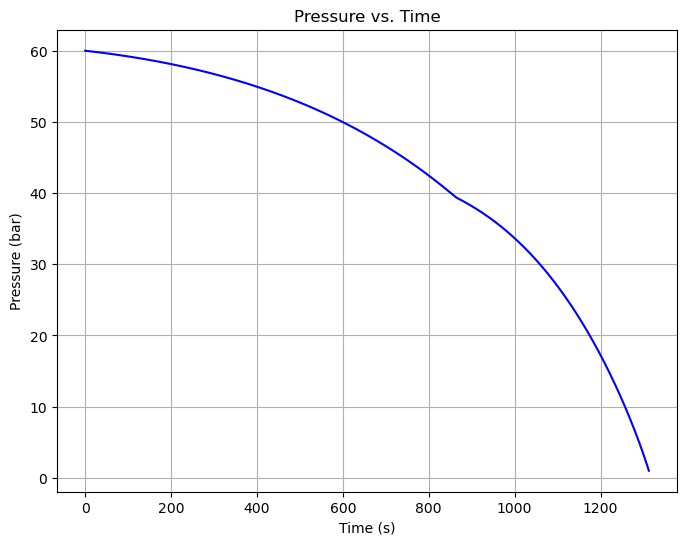

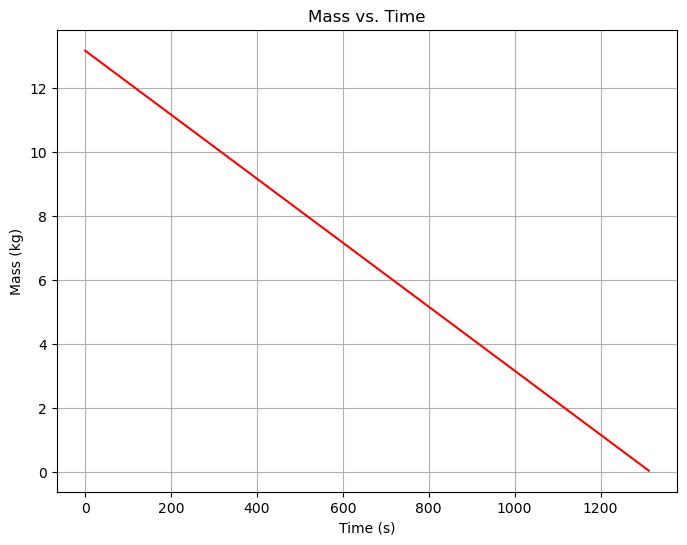

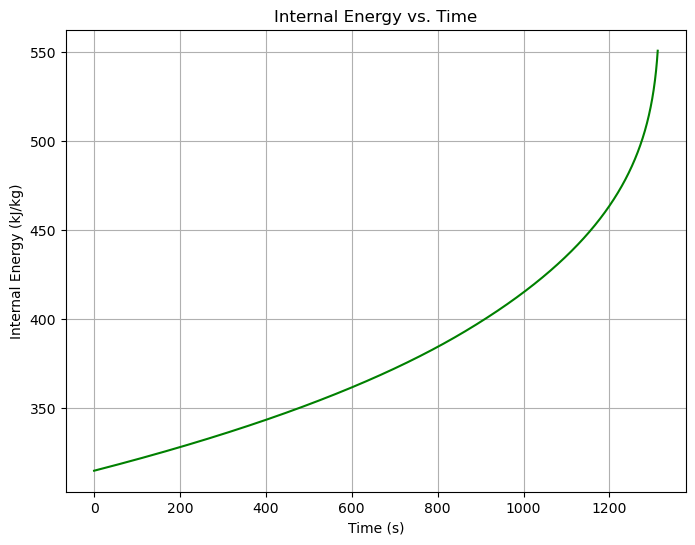

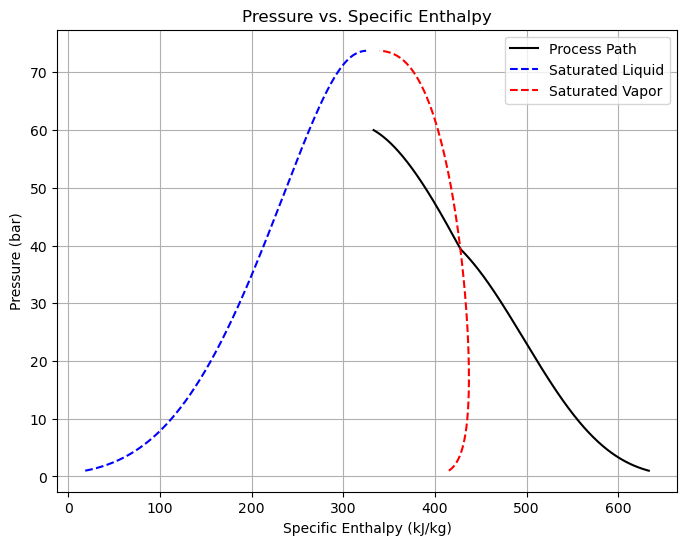

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pyCalor import thermo as th

# Define constants
V = 0.040 # Volume in m^3
p_initial_bar = 60 # Initial pressure in bar
p_final_bar = 1 # Final pressure in bar
x_initial = 0.5 # Initial quality
dt = 0.1 # Time step in seconds
mdot_out = 0.01 # Constant mass flow rate out in kg/s
#Wdot_net = -100 # Constant net work transfer rate in Watts
# Wdot_net = -1000 # Constant net work transfer rate in Watts

# Substance properties
substance = 'CO2' # Corrected substance name

# Initial conditions using pyCalor
try:
    st_initial = th.state(substance, p=(p_initial_bar, 'bar'), x=x_initial)
    m_initial = V / st_initial.v
    u_initial = st_initial.u * 1000 # Convert kJ/kg to J/kg
    h_initial = st_initial.h * 1000 # Convert kJ/kg to J/kg
    p_initial_pa = st_initial.p * 1000 # Convert kPa to Pa
    T_initial = st_initial.t
except Exception as e:
    print(f"Error initializing state: {e}")
    exit()

# Lists to store results
time = [0]
mass = [m_initial]
internal_energy = [u_initial]
pressure = [p_initial_pa]
temperature = [T_initial]
enthalpy = [h_initial]

# Simulation loop
t = 0
m_t = m_initial
u_t = u_initial

while pressure[-1] > p_final_bar * 1e5:
    # Get current properties to determine outlet enthalpy
    try:
        # We need two independent properties to define the state. We have the new
        # internal energy and the new specific volume (V/m).
        v_current = V / m_t
        u_current_kJ_kg = u_t / 1000
        st_current = th.state(substance, u=(u_current_kJ_kg, 'kJ/kg'), v=(v_current, 'm3/kg'))
        h_out = st_current.h * 1000 # Convert kJ/kg to J/kg
    except Exception as e:
        print(f"Error at time {t}: Could not define state with U={u_t} J/kg and v={v_current} m3/kg. {e}")
        break

    # Calculate new mass
    # See conservation of mass equation
    m_new = m_t - mdot_out * dt
    if m_new <= 0:
        break

    # Calculate new internal energy
    # See conservation of energy equation above
    u_new = (-Wdot_net * dt - mdot_out * h_out * dt + m_t * u_t) / m_new

    # Update variables for the next iteration
    t += dt
    m_t = m_new
    u_t = u_new

    # Get new pressure, temperature, and enthalpy from the updated state
    try:
        v_new = V / m_new
        u_new_kJ_kg = u_new / 1000
        st_new = th.state(substance, u=(u_new_kJ_kg, 'kJ/kg'), v=(v_new, 'm3/kg'))
        p_new = st_new.p * 1000 # Convert kPa to Pa
        T_new = st_new.t
        h_new = st_new.h * 1000 # Convert kJ/kg to J/kg
    except Exception as e:
        print(f"Error at time {t}: Could not find properties for U={u_new} J/kg and v={v_new} m3/kg. {e}")
        break

    # Append results
    time.append(t)
    mass.append(m_new)
    internal_energy.append(u_new)
    pressure.append(p_new)
    temperature.append(T_new)
    enthalpy.append(h_new)

# Calculate saturation lines for the P-h diagram
pc_bar = 76 
pressures_for_dome_bar = np.linspace(p_final_bar, pc_bar, 1000)
h_liquid = []
h_vapor = []

for p in pressures_for_dome_bar:
    try:
        st_liquid = th.state(substance, p=(p, 'bar'), x=0)
        h_liquid.append(st_liquid.h)
        st_vapor = th.state(substance, p=(p, 'bar'), x=1)
        h_vapor.append(st_vapor.h)
    except:
        # If a pressure is above the critical pressure, the state will not be found.
        # We can stop calculating the saturation curve.
        break

# 1. Plot Pressure vs. Time
plt.figure(figsize=(8, 6))
plt.plot(np.array(time), np.array(pressure) / 1e5, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (bar)')
plt.title('Pressure vs. Time')
plt.grid(True)
plt.savefig('pressure_vs_time.pdf')

# 2. Plot Mass vs. Time
plt.figure(figsize=(8, 6))
plt.plot(time, mass, 'r-')
plt.xlabel('Time (s)')
plt.ylabel('Mass (kg)')
plt.title('Mass vs. Time')
plt.grid(True)
plt.savefig('mass_vs_time.pdf')

# 3. Plot Internal Energy vs. Time
plt.figure(figsize=(8, 6))
plt.plot(time, np.array(internal_energy) / 1000, 'g-')
plt.xlabel('Time (s)')
plt.ylabel('Internal Energy (kJ/kg)')
plt.title('Internal Energy vs. Time')
plt.grid(True)
plt.savefig('internal_energy_vs_time.pdf')

# 4. Plot Pressure vs. Enthalpy with Saturation Dome
plt.figure(figsize=(8, 6))
plt.plot(np.array(enthalpy) / 1000, np.array(pressure) / 1e5, 'k-', label='Process Path')
plt.plot(h_liquid, pressures_for_dome_bar[:len(h_liquid)], 'b--', label='Saturated Liquid')
plt.plot(h_vapor, pressures_for_dome_bar[:len(h_vapor)], 'r--', label='Saturated Vapor')
plt.xlabel('Specific Enthalpy (kJ/kg)')
plt.ylabel('Pressure (bar)')
plt.title('Pressure vs. Specific Enthalpy')
plt.grid(True)
plt.legend()
plt.savefig('pressure_vs_enthalpy.pdf')